In [ ]:
!pip install os time pandas string numpy matplotlib tensorflow keras tokenizers


In [57]:
import os
import time
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders


## Loading the DataSet

In [2]:
bible_path = "/kaggle/input/bible-data"
quran_path = "/kaggle/input/quran-data"


train_en_bible_file = os.path.join(bible_path, "train.en")
train_ur_bible_file = os.path.join(bible_path, "train.ur")
val_en_bible_file = os.path.join(bible_path, "dev.en")
val_ur_bible_file = os.path.join(bible_path, "dev.ur")
test_en_bible_file = os.path.join(bible_path, "test.en")
test_ur_bible_file = os.path.join(bible_path, "test.ur")


train_en_quran_file = os.path.join(quran_path, "train.en")
train_ur_quran_file = os.path.join(quran_path, "train.ur")
val_en_quran_file = os.path.join(quran_path, "dev.en")
val_ur_quran_file = os.path.join(quran_path, "dev.ur")
test_en_quran_file = os.path.join(quran_path, "test.en")
test_ur_quran_file = os.path.join(quran_path, "test.ur")

def load_sentences(en_file_path, ur_file_path):
    en_sentences, ur_sentences = [], []
    with open(en_file_path, 'r', encoding='utf-8') as en_file, \
         open(ur_file_path, 'r', encoding='utf-8') as ur_file:
        for en_line, ur_line in zip(en_file, ur_file):
            en_sentences.append(en_line.strip())
            ur_sentences.append(ur_line.strip())
    return en_sentences, ur_sentences


train_en_bible, train_ur_bible = load_sentences(train_en_bible_file, train_ur_bible_file)
val_en_bible, val_ur_bible = load_sentences(val_en_bible_file, val_ur_bible_file)
test_en_bible, test_ur_bible = load_sentences(test_en_bible_file, test_ur_bible_file)

train_en_quran, train_ur_quran = load_sentences(train_en_quran_file, train_ur_quran_file)
val_en_quran, val_ur_quran = load_sentences(val_en_quran_file, val_ur_quran_file)
test_en_quran, test_ur_quran = load_sentences(test_en_quran_file, test_ur_quran_file)


train_en_combined = train_en_bible + train_en_quran
train_ur_combined = train_ur_bible + train_ur_quran

val_en_combined = val_en_bible + val_en_quran
val_ur_combined = val_ur_bible + val_ur_quran

test_en_combined = test_en_bible + test_en_quran
test_ur_combined = test_ur_bible + test_ur_quran


train_data = pd.DataFrame({'English': train_en_combined, 'Urdu': train_ur_combined})
val_data = pd.DataFrame({'English': val_en_combined, 'Urdu': val_ur_combined})
test_data = pd.DataFrame({'English': test_en_combined, 'Urdu': test_ur_combined})



## Data Preprocessing

In [3]:
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = ' '.join(text.split())
    return text.strip()

train_data['English'] = train_data['English'].apply(clean_text)
train_data['Urdu'] = train_data['Urdu'].apply(clean_text)

val_data['English'] = val_data['English'].apply(clean_text)
val_data['Urdu'] = val_data['Urdu'].apply(clean_text)

test_data['English'] = test_data['English'].apply(clean_text)
test_data['Urdu'] = test_data['Urdu'].apply(clean_text)

print("Cleaned training data sample:", train_data.head())
print("Cleaned validation data sample:", val_data.head())
print("Cleaned test data sample:", test_data.head())


Cleaned training data sample:                                              English  \
0  ﻿the book of the generation of jesus christ th...   
1  abraham begat isaac and isaac begat jacob and ...   
2  and judas begat phares and zara of thamar and ...   
3  and aram begat aminadab and aminadab begat naa...   
4  and salmon begat booz of rachab and booz begat...   

                                                Urdu  
0         ﻿یسوع مسیح ابن داود ابن ابرہام کا نسب نامہ  
1  ابراہام سے اضحاق پیدا ہوا اور اضحاق سے یعقوب پ...  
2  اور یہوداہ سے فارص اور زارح تمر سے پیدا ہوئے ا...  
3  اور رام سے عمینداب پیدا ہوا اور عمینداب سے نحس...  
4  اور سلمون سے بوعز راحب سے پیدا ہوا اور بوعز سے...  
Cleaned validation data sample:                                              English  \
0  this then is the message which we have heard o...   
1  if we say that we have fellowship with him and...   
2  but if we walk in the light as he is in the li...   
3  if we say that we have no sin we deceive our

## Tokenization 

In [ ]:
def train_bpe_tokenizer(texts, vocab_size=10000):
    tokenizer = Tokenizer(models.BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, min_frequency=2, show_progress=True)
    tokenizer.train_from_iterator(texts, trainer=trainer)
    return tokenizer

def tokenize_bpe(text, tokenizer):
    return tokenizer.encode(text).ids

In [4]:
train_texts = train_data['English'].tolist() + train_data['Urdu'].tolist()
val_texts = val_data['English'].tolist() + val_data['Urdu'].tolist()
test_texts = test_data['English'].tolist() + test_data['Urdu'].tolist()

bpe_tokenizer = train_bpe_tokenizer(train_texts)

train_data['English_tokens'] = train_data['English'].apply(lambda x: tokenize_bpe(x, bpe_tokenizer))
train_data['Urdu_tokens'] = train_data['Urdu'].apply(lambda x: tokenize_bpe(x, bpe_tokenizer))

val_data['English_tokens'] = val_data['English'].apply(lambda x: tokenize_bpe(x, bpe_tokenizer))
val_data['Urdu_tokens'] = val_data['Urdu'].apply(lambda x: tokenize_bpe(x, bpe_tokenizer))

test_data['English_tokens'] = test_data['English'].apply(lambda x: tokenize_bpe(x, bpe_tokenizer))
test_data['Urdu_tokens'] = test_data['Urdu'].apply(lambda x: tokenize_bpe(x, bpe_tokenizer))

print("Tokenized training data sample:\n", train_data[['English_tokens', 'Urdu_tokens']].head())





Tokenized training data sample:
                                       English_tokens  \
0  [89, 91, 852, 114, 91, 3571, 114, 424, 591, 91...   
1  [1346, 3403, 3770, 95, 3770, 3403, 2833, 95, 2...   
2  [95, 4007, 3403, 1746, 447, 95, 30, 138, 5, 11...   
3  [95, 138, 289, 3403, 289, 94, 285, 267, 95, 28...   
4  [95, 2157, 1155, 3403, 477, 8623, 114, 22, 380...   

                                         Urdu_tokens  
0  [89, 441, 626, 1796, 4139, 1796, 2543, 147, 62...  
1  [9378, 9409, 117, 5545, 711, 702, 99, 5545, 11...  
2  [99, 3660, 117, 8157, 52, 99, 2903, 44, 137, 4...  
3  [99, 1391, 117, 56, 502, 5303, 711, 702, 99, 5...  
4  [99, 862, 217, 117, 413, 6450, 9373, 40, 117, ...  


## Padding for training the Transformer


In [6]:
max_urdu_len_train =   max(train_data['Urdu_tokens'].apply(len))

train_data['English_tokens'] = train_data['English_tokens'].apply(lambda x: pad_sequences([x], maxlen=max_urdu_len_train, padding='post', truncating='post')[0])

train_data['Urdu_tokens'] = train_data['Urdu_tokens'].apply(lambda x: pad_sequences([x], maxlen=max_urdu_len_train, padding='post', truncating='post')[0])

val_data['English_tokens'] = val_data['English_tokens'].apply(lambda x: pad_sequences([x], maxlen=max_urdu_len_train, padding='post', truncating='post')[0])
val_data['Urdu_tokens'] = val_data['Urdu_tokens'].apply(lambda x: pad_sequences([x], maxlen=max_urdu_len_train, padding='post', truncating='post')[0])


test_data['English_tokens'] = test_data['English_tokens'].apply(lambda x: pad_sequences([x], maxlen=max_urdu_len_train, padding='post', truncating='post')[0])
test_data['Urdu_tokens'] = test_data['Urdu_tokens'].apply(lambda x: pad_sequences([x], maxlen=max_urdu_len_train, padding='post', truncating='post')[0])


print("Padded training data sample:\n", train_data[['English_tokens']].head())
print("Padded validation data sample:\n", val_data[['English_tokens']].head())



# Inspect the lengths of English and Urdu tokens
val_data['English_token_length'] = val_data['English_tokens'].apply(len)
val_data['Urdu_token_length'] = val_data['Urdu_tokens'].apply(len)

# Display the lengths alongside the data
print(val_data[['English_tokens', 'English_token_length', 'Urdu_tokens', 'Urdu_token_length']].head())


Padded training data sample:
                                       English_tokens
0  [89, 91, 852, 114, 91, 3571, 114, 424, 591, 91...
1  [1346, 3403, 3770, 95, 3770, 3403, 2833, 95, 2...
2  [95, 4007, 3403, 1746, 447, 95, 30, 138, 5, 11...
3  [95, 138, 289, 3403, 289, 94, 285, 267, 95, 28...
4  [95, 2157, 1155, 3403, 477, 8623, 114, 22, 380...
Padded validation data sample:
                                       English_tokens
0  [269, 272, 101, 91, 4538, 248, 152, 228, 1105,...
1  [249, 152, 301, 148, 152, 228, 6923, 208, 178,...
2  [233, 249, 152, 2587, 94, 91, 1010, 141, 129, ...
3  [249, 152, 301, 148, 152, 228, 140, 635, 152, ...
4  [249, 152, 4823, 286, 1433, 129, 101, 3264, 95...
                                      English_tokens  English_token_length  \
0  [269, 272, 101, 91, 4538, 248, 152, 228, 1105,...                   256   
1  [249, 152, 301, 148, 152, 228, 6923, 208, 178,...                   256   
2  [233, 249, 152, 2587, 94, 91, 1010, 141, 129, ...                

## Transformer Implementation

### Hyper Parameter Tuning

In [32]:
MAX_LEN_EN = max([len(seq) for seq in train_data['English_tokens']])
MAX_LEN_UR = max([len(seq) for seq in train_data['Urdu_tokens']])
MAX_LEN = max(MAX_LEN_EN, MAX_LEN_UR)

D_MODEL = 512
NUM_HEADS = 2
NUM_LAYERS = 6
HIDDEN_UNITS = 512
DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
EPOCHS = 5


### Building the Encoder and Decoder

In [33]:
def get_positional_encoding(seq_len, d_model):

    position = tf.range(seq_len, dtype=tf.float32)
    position = position[:, tf.newaxis]  # Shape (seq_len, 1)
    
    div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / d_model))
    pos_encoding = position * div_term
    pos_encoding = tf.concat([tf.sin(pos_encoding), tf.cos(pos_encoding)], axis=-1)
    
    pos_encoding = pos_encoding[tf.newaxis, ...] 
    return pos_encoding

def transformer_encoder(inputs, num_heads, hidden_units, dropout_rate):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=D_MODEL)(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    
    ffn_output = layers.Dense(hidden_units, activation='relu')(out1)
    ffn_output = layers.Dense(D_MODEL)(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    return out2

def transformer_decoder(inputs, enc_output, num_heads, hidden_units, dropout_rate):
    attn_output1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=D_MODEL)(inputs, inputs)
    attn_output1 = layers.Dropout(dropout_rate)(attn_output1)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output1)
    
    attn_output2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=D_MODEL)(out1, enc_output)
    attn_output2 = layers.Dropout(dropout_rate)(attn_output2)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + attn_output2)
    
    ffn_output = layers.Dense(hidden_units, activation='relu')(out2)
    ffn_output = layers.Dense(D_MODEL)(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    out3 = layers.LayerNormalization(epsilon=1e-6)(out2 + ffn_output)
    
    return out3

def build_transformer_model(english_vocab_size, urdu_vocab_size, max_seq_length, D_MODEL, NUM_HEADS, NUM_LAYERS, HIDDEN_UNITS, DROPOUT_RATE):
    encoder_inputs = layers.Input(shape=(max_seq_length,), name="encoder_inputs")
    encoder_embedding = layers.Embedding(english_vocab_size, D_MODEL)(encoder_inputs)
    
    pos_encoding = get_positional_encoding(max_seq_length, D_MODEL)
    encoder_embedding += pos_encoding[:, :max_seq_length, :]
    
    enc_output = encoder_embedding
    for _ in range(NUM_LAYERS):
        enc_output = transformer_encoder(enc_output, NUM_HEADS, HIDDEN_UNITS, DROPOUT_RATE)
    
    decoder_inputs = layers.Input(shape=(max_seq_length,), name="decoder_inputs")
    decoder_embedding = layers.Embedding(urdu_vocab_size, D_MODEL)(decoder_inputs)
    
    decoder_pos_encoding = get_positional_encoding(max_seq_length, D_MODEL)
    decoder_embedding += decoder_pos_encoding[:, :max_seq_length, :]
    
    dec_output = decoder_embedding
    for _ in range(NUM_LAYERS):
        dec_output = transformer_decoder(dec_output, enc_output, NUM_HEADS, HIDDEN_UNITS, DROPOUT_RATE)
    
    decoder_dense = layers.TimeDistributed(layers.Dense(urdu_vocab_size, activation='softmax'))(dec_output)

    model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_dense)
    
    return model

In [34]:
transformer_model = build_transformer_model(english_vocab_size, urdu_vocab_size, MAX_LEN, D_MODEL, NUM_HEADS, NUM_LAYERS, HIDDEN_UNITS, DROPOUT_RATE)

transformer_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [35]:
encoder_input_data = np.array(train_data['English_tokens'].tolist())
decoder_input_data = np.array(train_data['Urdu_tokens'].tolist())
decoder_target_data = np.expand_dims(np.roll(decoder_input_data, shift=-1, axis=1), -1)

history = transformer_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        [np.array(val_data['English_tokens'].tolist()), np.array(val_data['Urdu_tokens'].tolist())],
        np.expand_dims(np.roll(np.array(val_data['Urdu_tokens'].tolist()), shift=-1, axis=1), -1)
    ),
    verbose=1
)


Epoch 1/5


W0000 00:00:1731786504.153009     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731786642.734913     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_53', 432 bytes spill stores, 468 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 152 bytes spill stores, 184 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 68 bytes spill stores, 68 bytes spill loads



31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7853 - loss: 4.4752

W0000 00:00:1731786665.140215     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1731786792.083365     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_51', 36 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_40', 432 bytes spill stores, 468 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_39', 48 bytes spill stores, 48 bytes spill loads



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7880 - loss: 4.4289   

W0000 00:00:1731786798.307904     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731786810.180043     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 368s 6s/step - accuracy: 0.7905 - loss: 4.3855 - val_accuracy: 0.8773 - val_loss: 1.6476
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 592ms/step - accuracy: 0.8994 - loss: 1.3533 - val_accuracy: 0.8773 - val_loss: 1.2186
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.8989 - loss: 1.0278 - val_accuracy: 0.8773 - val_loss: 1.1630
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 590ms/step - accuracy: 0.9010 - loss: 0.9588 - val_accuracy: 0.8773 - val_loss: 1.1473
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 591ms/step - accuracy: 0.9016 - loss: 0.9357 - val_accuracy: 0.8773 - val_loss: 1.1312


### Test Data Evaluation

In [51]:
start_time = time.time()

test_encoder_input = np.array(test_data['English_tokens'].tolist())
test_decoder_input = np.array(test_data['Urdu_tokens'].tolist())
test_decoder_target = np.expand_dims(np.roll(test_decoder_input, shift=-1, axis=1), -1)

test_loss, test_accuracy = transformer_model.evaluate([test_encoder_input, test_decoder_input], test_decoder_target)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

end_time = time.time()

transformer_perplexity = np.exp(test_loss)

transformer_time = end_time - start_time

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.8592 - loss: 1.3124
Test Loss: 1.3282160758972168, Test Accuracy: 0.8574023246765137


### Accuracy and Loss Plots

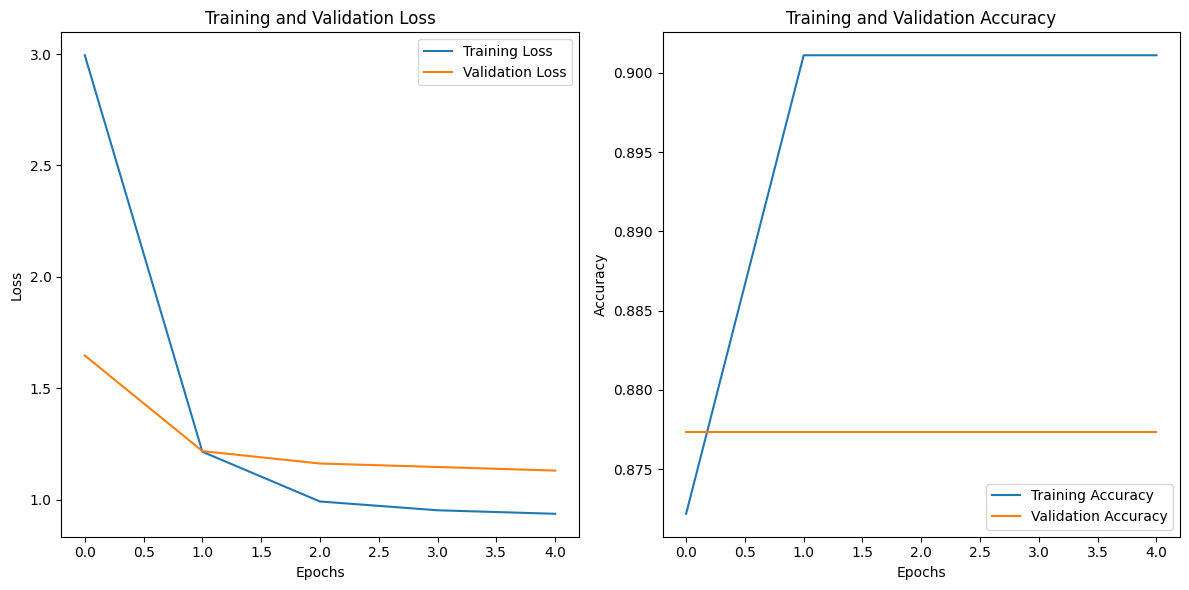

In [37]:

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Function for Finding out Vocabulary

In [9]:
def get_vocab_size(tokenized_data):
    """Get the maximum token ID from the data and add 1 for padding"""
    max_token = max(max(max(seq) for seq in tokenized_data['English_tokens']),
                   max(max(seq) for seq in tokenized_data['Urdu_tokens']))
    return max_token + 1

## LSTM Implementation

### HyperParameters

In [21]:
embedding_dim = 128
lstm_units = 256
batch_size = 32
epochs = 10
dropout_rate = 0.1


In [22]:
train_data = train_data[:10000]
val_data = val_data[:200]
test_data = test_data[:200]


english_vocab_size = get_vocab_size(train_data)
urdu_vocab_size = get_vocab_size(train_data)

### The LSTM Model Function

In [23]:
def build_lstm_model(english_vocab_size, urdu_vocab_size, max_seq_length, embedding_dim, lstm_units):
    encoder_inputs = Input(shape=(max_seq_length,), name="encoder_inputs")
    encoder_embedding = Embedding(english_vocab_size, embedding_dim, mask_zero=True, name="encoder_embedding")(encoder_inputs)
    encoder_lstm = LSTM(lstm_units, return_state=True, dropout=dropout_rate, name="encoder_lstm")
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = Input(shape=(max_seq_length,), name="decoder_inputs")
    decoder_embedding = Embedding(urdu_vocab_size, embedding_dim, mask_zero=True, name="decoder_embedding")(decoder_inputs)
    decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=dropout_rate, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(urdu_vocab_size, activation="softmax"), name="decoder_dense")
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model


In [24]:
max_seq_length = max_urdu_len_train  
lstm_model = build_lstm_model(english_vocab_size, urdu_vocab_size, max_seq_length, embedding_dim, lstm_units)


lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Model Training

In [26]:
encoder_input_data = np.array(train_data['English_tokens'].tolist())
decoder_input_data = np.array(train_data['Urdu_tokens'].tolist())
decoder_target_data = np.expand_dims(np.roll(decoder_input_data, shift=-1, axis=1), -1)  # Target shifted by 1

history = lstm_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [np.array(val_data['English_tokens'].tolist()), np.array(val_data['Urdu_tokens'].tolist())],
        np.expand_dims(np.roll(np.array(val_data['Urdu_tokens'].tolist()), shift=-1, axis=1), -1)
    ),
    verbose=1  
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step - accuracy: 0.1211 - loss: 5.8585 - val_accuracy: 0.0069 - val_loss: 6.1739
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 923ms/step - accuracy: 0.4809 - loss: 5.8127 - val_accuracy: 0.0089 - val_loss: 6.1360
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 924ms/step - accuracy: 0.0097 - loss: 5.7340 - val_accuracy: 0.0113 - val_loss: 6.0514
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 926ms/step - accuracy: 0.0106 - loss: 5.6399 - val_accuracy: 0.0116 - val_loss: 5.9063
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 917ms/step - accuracy: 0.0106 - loss: 5.5199 - val_accuracy: 0.0124 - val_loss: 5.8417
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 918ms/step - accuracy: 0.0119 - loss: 5.3925 - val_accuracy: 0.0130 - val_loss: 5.8628
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 917ms/step - accuracy: 0.0127 - loss: 5.3112 - val_accuracy: 0.0130 - val_loss: 5.7854
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 931ms/step - accuracy: 0.0131 - loss: 5.2175 - val_accu

### Model Evaluation and Loss and Accuracy Plots

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.0167 - loss: 6.0638
Test Loss: 6.06246280670166, Test Accuracy: 0.01718750037252903


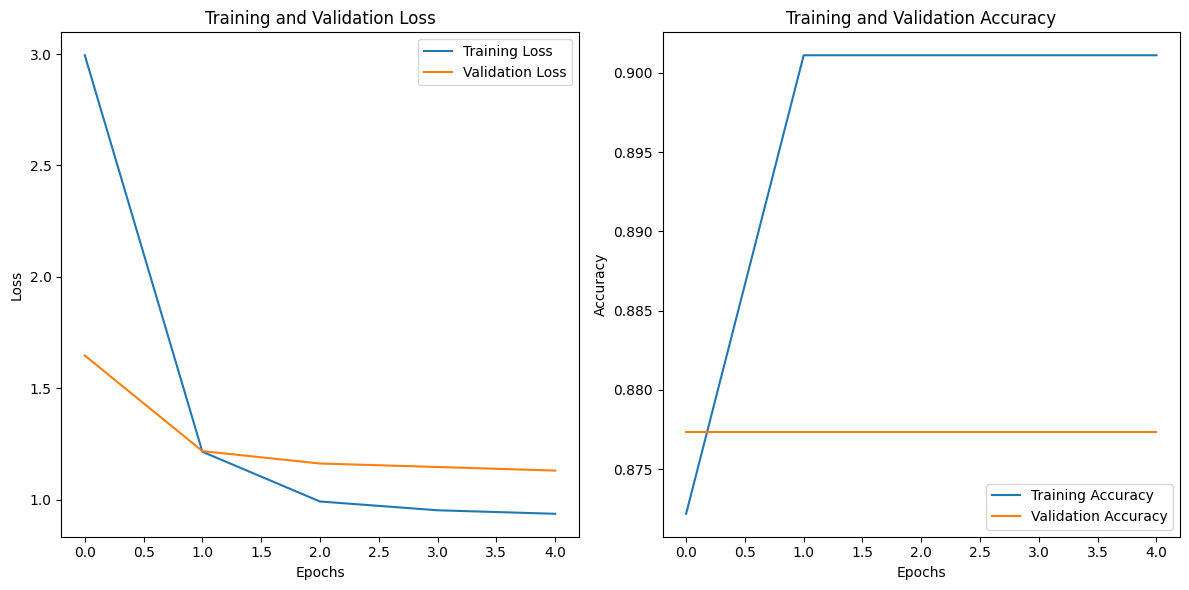

In [52]:
start_time = time.time()
test_encoder_input = np.array(test_data['English_tokens'].tolist())
test_decoder_input = np.array(test_data['Urdu_tokens'].tolist())
test_decoder_target = np.expand_dims(np.roll(test_decoder_input, shift=-1, axis=1), -1)

test_loss, test_accuracy = lstm_model.evaluate([test_encoder_input, test_decoder_input], test_decoder_target)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

end_time = time.time()

lstm_perplexity = np.exp(test_loss)

lstm_time = end_time - start_time

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Model Comparisons

### Accuracy Plots Above

### Inference Time

In [53]:
print("LSTM Prediction Time" , lstm_time)

print("Transformer Prediction Time", transformer_time)

LSTM Prediction Time 1.7120978832244873
Transformer Prediction Time 1.1551399230957031


### Perplexity

In [54]:
print("Transformer Perplexity" , transformer_perplexity)

print("LSTM Perplexity" , lstm_perplexity)

Transformer Perplexity 3.7743043059283083
LSTM Perplexity 429.4317429609724
